# Bases d'Atom

## Manipulation de la trace

In [ ]:
from atom import *
import numpy as np
import random as rd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)

La méthode `generate` prend en entrée une liste d'assets, un nombre d'agent (ZIT) à créer et un nombre de tours de paroles à faire. Le marché a deux paramètres, tous les deux optionnels :
* `out` qui est l'output dans lequel il faut écrire la trace. Par défaut, si rien n'est précisé, cet output est la console.
* `print_orderbooks` est un booléen valant `False` par défaut. Il indique s'il faut afficher les orderbooks à la fin de chaque tick.

In [40]:
m = Market(print_orderbooks=True)
m.generate(['Apple', 'Google'], 3, 3) # 3 ZIT faisant 2 tours de parole sur les assets Apple et Google
m.print_state()

# Order;asset;agent;direction;price;qty
# Tick;nb_tick
# or Tick;nb_tick;asset;last_price
# Price;asset;bider;asker;price;qty
# Agent;name;money;last_modified_asset;qty

Order;Apple;ZIT 249;BID;58;89
Order;Google;ZIT 251;ASK;53;93
Order;Apple;ZIT 250;BID;93;95
Tick;1

OrderBook Apple:
Asks:
	Empty
Bids:
	BID Apple at 93.00 x 95 from ZIT 250
	BID Apple at 58.00 x 89 from ZIT 249


OrderBook Google:
Asks:
	ASK Google at 53.00 x 93 from ZIT 251
Bids:
	Empty

Order;Google;ZIT 251;BID;26;2
Order;Google;ZIT 250;ASK;55;66
Order;Apple;ZIT 249;ASK;14;33
Price;Apple;ZIT 250;ZIT 249;93;33
Agent;ZIT 249;3069;Apple;-33
Agent;ZIT 250;-3069;Apple;33
Tick;2;Apple;93

OrderBook Apple:
Asks:
	Empty
Bids:
	BID Apple at 93.00 x 62 from ZIT 250
	BID Apple at 58.00 x 89 from ZIT 249


OrderBook Google:
Asks:
	ASK Google at 53.00 x 93 from ZIT 251
	ASK Google at 55.00 x 66 from ZIT 250
Bids:
	BID Google at 26.00 x 2 from ZIT 251

Order;Apple;ZIT 249;BID;76;56
Order;Apple;ZIT 251;ASK;73;21
Price;Apple;ZIT 250

On peut aussi demander à atom d'écrire la trace dans un fichier, pour pouvoir ensuite traiter les données.

In [38]:
out = open('trace.dat', 'w')
# Remarque : En faisant out = open('/dev/null', 'w'), la trace n'est ni affichée dans la console, ni écrite dans un fichier

m = Market(out)
m.generate(['Apple', 'Google'], 5, 100)

out.close() # Remarque : Avec Jupyter, il est IMPÉRATIF de penser à fermer le fichier...

## Utilisation de la trace pour afficher différentes courbes

### Affichage des prix

En récupérant les données écrites dans trace.dat, on peut afficher les prix tick par tick...

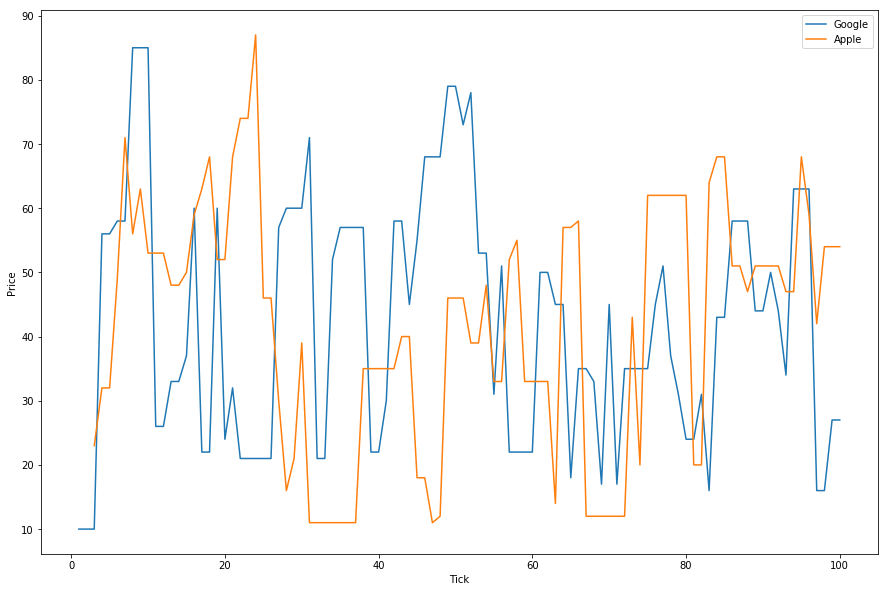

In [22]:
Prices = process_prices_per_tick('trace.dat')
# process_prices_per_tick prend un nom de fichier, le lit, et retourne un dictionnaire dont les clés sont les assets
# et les valeurs un tuple de listes : la première contient les différents tick et la second, le dernier prix prit par 
# l'asset à chaque tick
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Tick')
plt.ylabel('Price')
plt.show()

Cependant, plusieurs prix peuvent être fixés dans un tick donné. Pour un asset donné, on peut aussi afficher la séquence de l'ensemble des prix fixés.

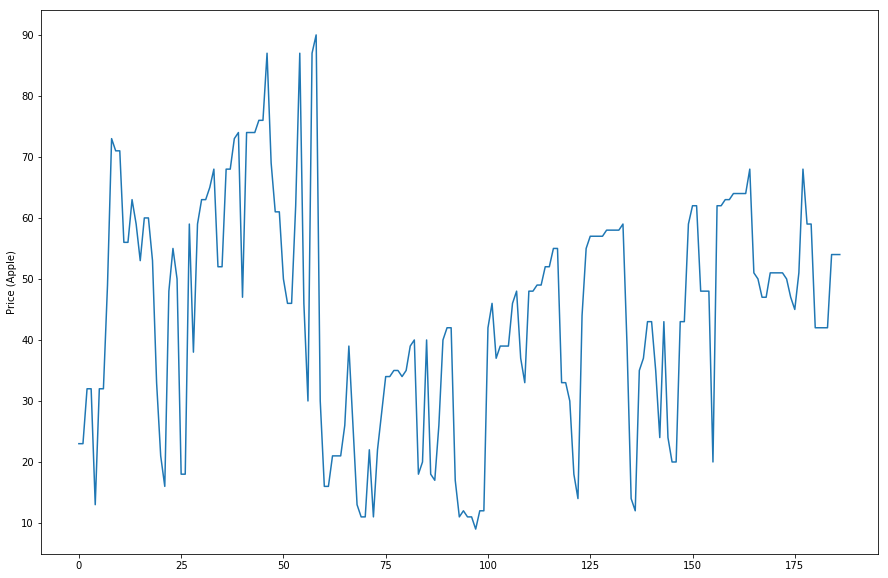

In [23]:
asset = 'Apple'
Prices = process_prices('trace.dat', asset)
# process_prices prend un nom de fichier et le nom d'un asset, et retourne l'ensemble des prix prit par cet asset dans
# la trace écrite dans le fichier
plt.plot(Prices, '-')
plt.ylabel('Price ('+asset+')')
plt.show()

### Affichage de l'évolution du wealth des agents

À la fin d'une simulation, on peut accéder au wealth d'un agent avec la méthode `get_wealth` (qui prend le marché en paramètre). Par exemple, on peut afficher les caractéristiques de l'agent le plus riche et du plus pauvre:

In [24]:
t_max = m.traders[0]
t_min = m.traders[0]
for t in m.traders:
    if t.get_wealth(m) > t_max.get_wealth(m):
        t_max = t
    elif t.get_wealth(m) < t_max.get_wealth(m):
        t_min = t
print(t_max.get_infos(m))
print(t_min.get_infos(m))

ZIT 226:
Money: -1025
Apple: 281
Google: -74
Wealth: 12151

ZIT 223:
Money: 11418
Apple: 264
Google: -761
Wealth: 5127



On peut aussi afficher l'évolution du wealth de tous les agents, en lisant la trace.

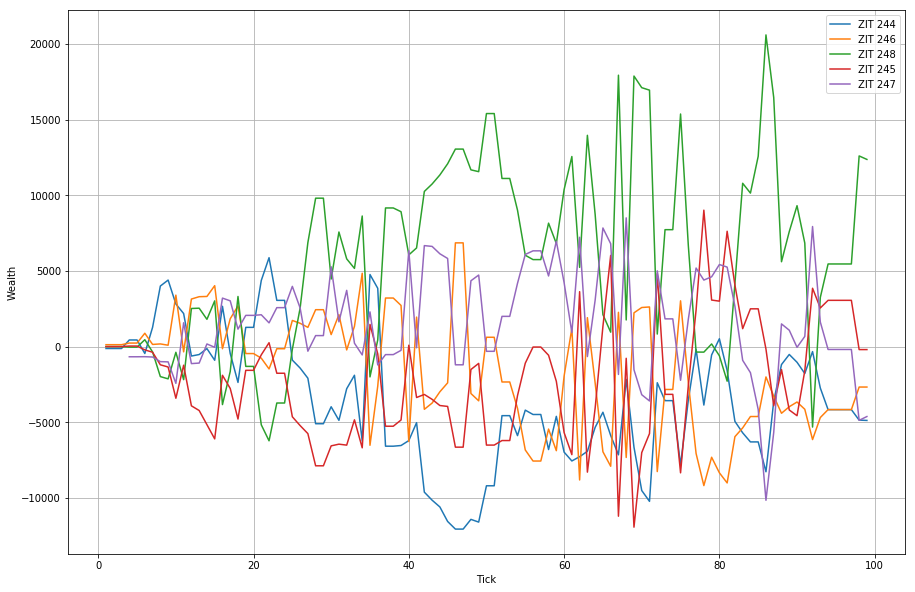

In [39]:
Wealth = process_wealth('trace.dat')
# process_wealth prend en entrée le nom du fichier dans lequel la trace est écrite
# et retourne un dictionnaire dont les clés sont les noms des agents
# et la valeur un tuple (liste des ticks, liste des wealth)
plt.clf()
for agent in Wealth.keys():
    T, W = Wealth[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Tick')
plt.ylabel('Wealth')
plt.show()

### Bien-être social 

On peut aussi afficher l'évolution du bien-être social selon le tick. Le bien-être social peut-être définit comme :
* Bien-être utilitariste : $\sum_{a \in Agents}w_a$
* Bien-être égalitaire / min / de Rawls : $\min_{a \in Agents}w_a$
* Bien-être élitiste / max : $\max_{a \in Agents}w_a$
* Bien-être de Nash : $\prod_{a \in Agents}w_a$

où $w_a$ est le bien-être individuel de l'agent $a$ à un instant donné. On dispose de deux fonctions pour récupérer ce bien-être depuis la trace :
* `process_social_welfare(filename, welfare_type)` avec welfare_type valant 'utilitarian', 'min', 'max' ou 'nash' et qui retourne un tuple (Tick, Welfare)
* `process_all_social_welfare(filename)` qui retourne un tuple (Tick, Welfare) où Welfare est un dictionnaire dont les clés sont 'utilitarian', 'min', 'max' ou 'nash' et les valeurs sont les listes des valeurs prises par les différents bien-êtres sociaux. Pour pouvoir comparer ces différents welfares, les valeurs sont normalisées pour être comprises entre 0 et 1.

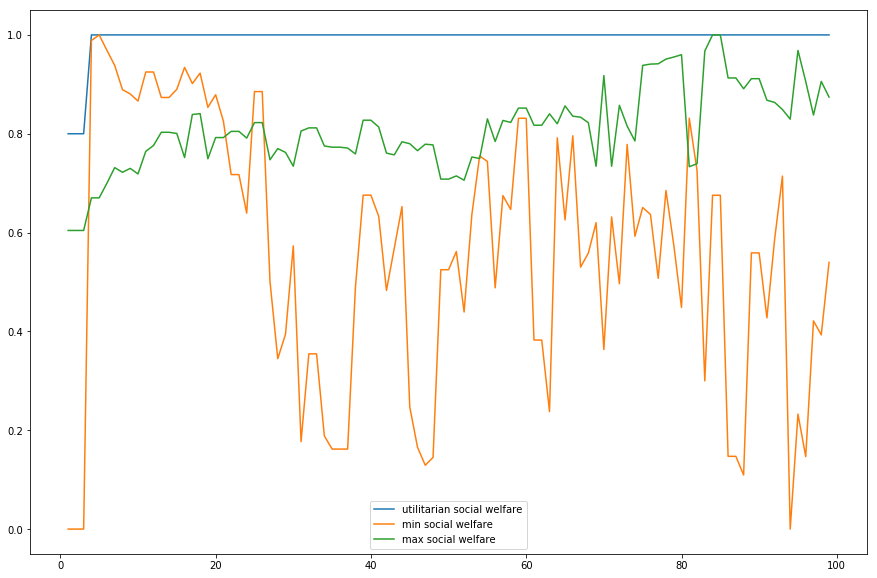

In [26]:
Tick, Welfare = process_all_social_welfare('trace.dat')
for welfare_type in Welfare.keys():
    plt.plot(Tick, Welfare[welfare_type], '-', label=welfare_type+' social welfare')
plt.legend(loc='best')
plt.show()

### Affichage des rentabilités

On peut aussi afficher la séquence des rentabilités en utilisant numpy : si $p_n$ est le $n$-ème élément de Prices, alors
> (Prices[1:]-Prices[:-1])/Prices[:-1] (resp. np.log(Prices[1:]) - np.log(Prices[:-1]))

donne la séquence des $\dfrac{p_{n+1}-p_n}{p_n}$ (resp. $\ln(p_{n+1})-\ln(p_n)$).

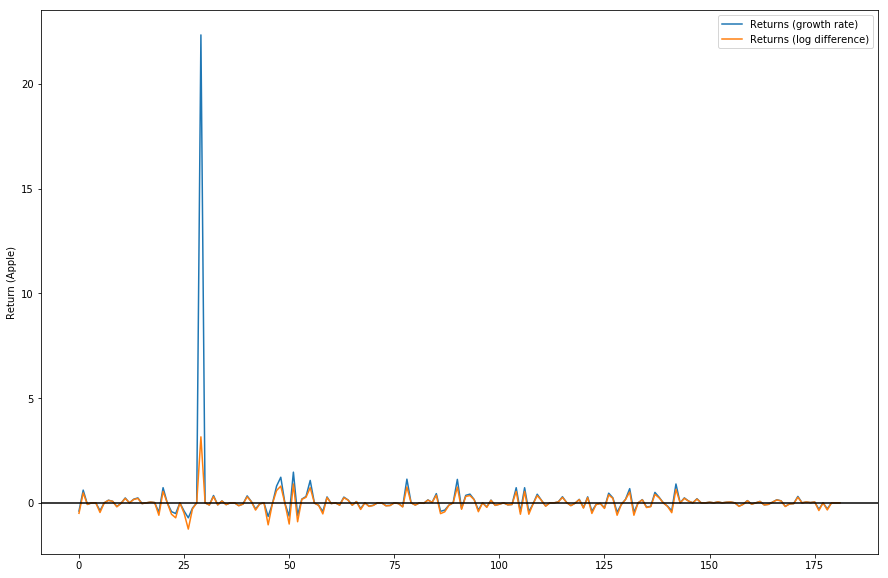

In [33]:
Prices = np.array(process_prices('trace.dat', asset))
Returns = (Prices[1:]-Prices[:-1])/Prices[:-1]
Returns_eco = np.log(Prices[1:]) - np.log(Prices[:-1])
plt.plot(Returns, '-', label="Returns (growth rate)")
plt.plot(Returns_eco, '-', label="Returns (log difference)")
plt.axhline(0, color='k')
plt.ylabel('Return ('+asset+')')
plt.legend(loc='best')
plt.show()

In [27]:
# Pour la suite, pour avoir de jolies courbes, mieux vaut avoir beaucoup de points...
out = open('trace.dat', 'w')
m = Market(out)
m.generate(['Apple', 'Google'], 10, 10000)
out.close()

Ou alors, on peut affichier l'histogramme des rentabilités (définies comme la différence logarithmique) :

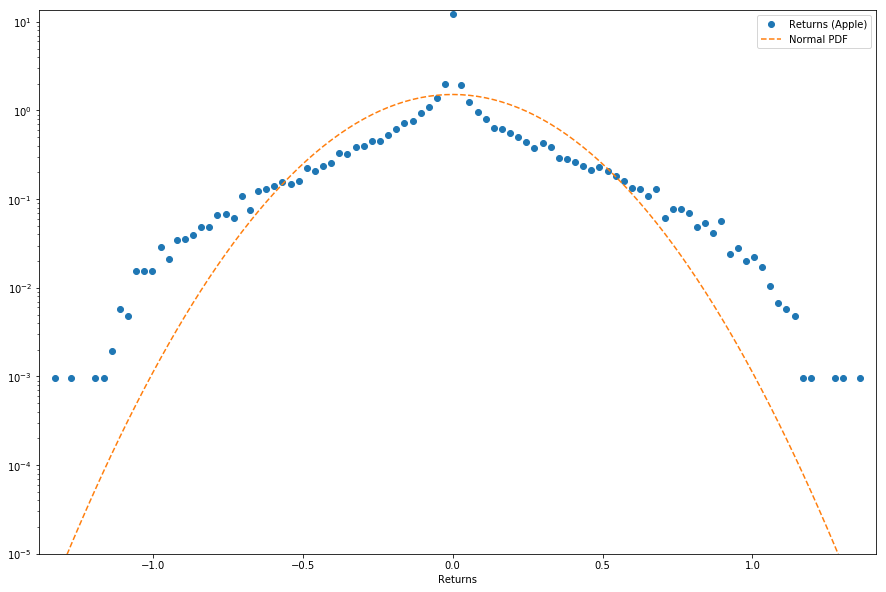

In [29]:
R, D, N = process_returns_hist('trace.dat', asset, 100)
# process_returns_hist prend un fichier, un asset et un nombre de points, et retourne un triplet (R, D, N) avec
# R les rentabilités (définies comme la différence logarithmique), D leur densité
# et N leur densité si la distribution de ces rentabilités suivait une loi normale de même espérance et écart-type.
plt.semilogy(R, D, 'o', label='Returns ('+asset+')')
plt.semilogy(R, N, '--', label='Normal PDF')
plt.xlabel('Returns')
plt.legend(loc='best')
plt.axis([min(R)*1.04, max(R)*1.04, 10**-5, max(D)*1.1])
plt.show()

On observe bien le fait stylisé associé à la rentabilité : par rapport à une gaussienne de même espérance et même écart type, on a une forte kurtosis (pic central de plus grande amplitude) et des queues plus épaisses.

### Histogramme des rentabilité quand les prix sont fixés aléatoirement

Le but de cette partie est de montrer que le fait stylisé qu'on obtient avec un marché financier à carnet d'ordres asynchrone ne peut être obtenu avec des prix fixés aléatoirement.
On va générer une fausse trace dans laquelle des prix (500000) sont fixés aléatoirement uniformément entre 1 et 100.

In [30]:
out = open('fake_trace.dat', 'w')
for i in range(500000):
    out.write("Price;Apple;ZIT 0;ZIT 0;"+str(rd.randint(1, 100))+";1\n")
out.close()

On va alors afficher l'histogramme des rentabilités.

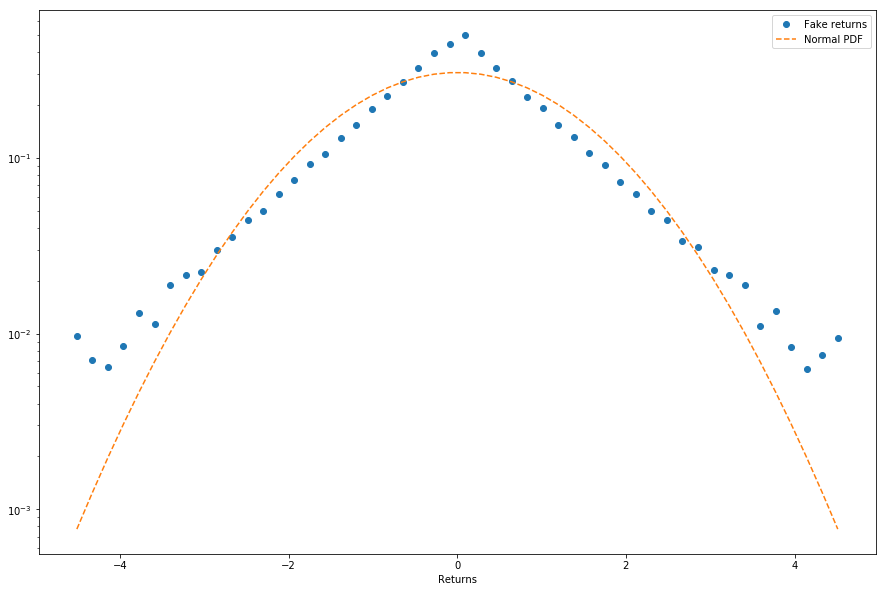

In [31]:
R, D, N = process_returns_hist('fake_trace.dat', 'Apple', 50)
# process_returns_hist prend un fichier, un asset et un nombre de points, et retourne un triplet (R, D, N) avec
# R les rentabilités (définies comme la différence logarithmique), D leur densité
# et N leur densité si la distribution de ces rentabilités suivait une loi normale de même espérance et écart-type.
plt.semilogy(R, D, 'o', label='Fake returns')
plt.semilogy(R, N, '--', label='Normal PDF')
plt.xlabel('Returns')
plt.legend(loc='best')
plt.show()

On n'observe plus une sorte de gausienne avec un gros pic et des queues épaisses, mais deux demi-droites.

## Utilisation de replay

On peut passer au marché un fichier d'ordres, dans lequel chaque ligne est un ordre de la forme `Order;asset;direction;price;qty`.

In [34]:
m = Market()
m.add_asset(OrderBook('LVMH'))

m.replay('orderFileEx1.dat')

m.print_state()

# Order;asset;agent;direction;price;qty
# Tick;nb_tick
# or Tick;nb_tick;asset;last_price
# Price;asset;bider;asker;price;qty
# Agent;name;money;last_modified_asset;qty

Order;LVMH;242;BID;45500;13
Order;LVMH;242;BID;42000;14
Order;LVMH;242;ASK;12000;10
Price;LVMH;242;242;45500;10
Order;LVMH;242;BID;45800;17
Order;LVMH;242;ASK;11500;10
Price;LVMH;242;242;45800;10
Order;LVMH;242;ASK;36000;12
Price;LVMH;242;242;45800;7
Price;LVMH;242;242;45500;3
Price;LVMH;242;242;42000;2
Order;LVMH;242;ASK;38500;12
Price;LVMH;242;242;42000;12
Order;LVMH;242;BID;34000;34
Order;LVMH;242;ASK;19000;18
Price;LVMH;242;242;34000;18
Order;LVMH;242;ASK;11700;11
Price;LVMH;242;242;34000;11
Order;LVMH;242;ASK;24000;5
Price;LVMH;242;242;34000;5

# Nb orders received: 11
# Nb fixed prices: 9
# Leaving ask size: 0
# Leaving bid size: 0


On peut aussi afficher la séquence des prix en précisant un fichier de sortie.

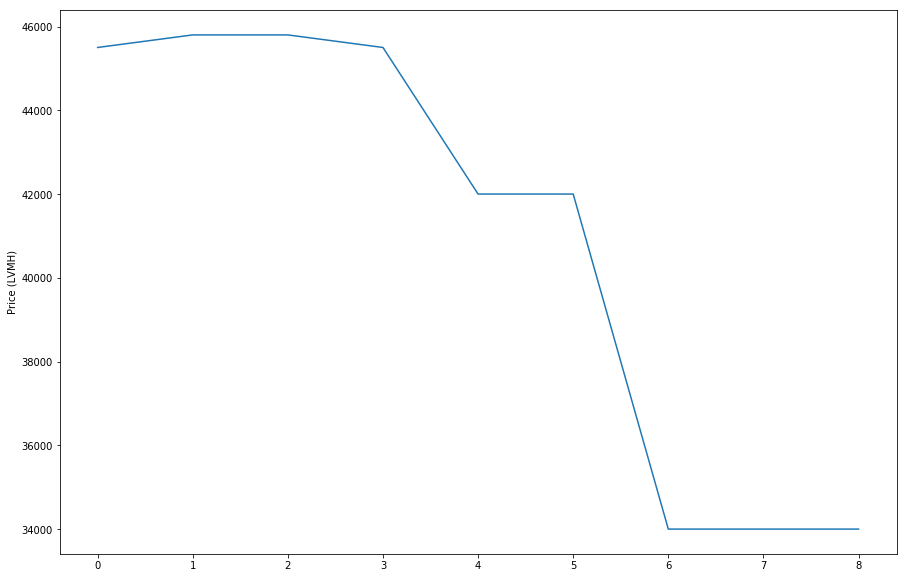

In [35]:
out = open('orderFileEx1output.dat', 'w')
m = Market(out)
m.add_asset(OrderBook('LVMH'))
m.replay('orderFileEx1.dat')
out.close()
Prices = process_prices('orderFileEx1output.dat', 'LVMH')
plt.plot(Prices, '-')
plt.ylabel('Price (LVMH)')
plt.show()